# Privacy-Preserving LLM Framework

This notebook implements a federated learning framework with DistilBERT for privacy-preserving healthcare models on the Chest X-Ray dataset. It includes simulated encryption for testing, with plans for homomorphic encryption integration.

# Install Dependencies

In [1]:
!pip install transformers==4.41.2 torch==2.3.0 cryptography==42.0.0 matplotlib==3.9.0 pandas==2.2.2 scikit-learn==1.5.0
!pip install torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.2/779.2 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 90.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 98.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 71.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 95.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56

# Import Libraries

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Setup Kaggle
!mkdir -p ~/.config/kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.config/kaggle/
!chmod 600 ~/.config/kaggle/kaggle.json


Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import os, glob, time, logging
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW

logging.basicConfig(level=logging.INFO)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Data Loading

In [4]:
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()
api.dataset_download_files('paultimothymooney/chest-xray-pneumonia', path='./chest_xray', unzip=True)

normal_files = glob.glob('./chest_xray/chest_xray/train/NORMAL/*.jpeg')
pneumonia_files = glob.glob('./chest_xray/chest_xray/train/PNEUMONIA/*.jpeg')
texts = [f"X-ray image {os.path.basename(f)}" for f in normal_files + pneumonia_files]
labels = [0]*len(normal_files) + [1]*len(pneumonia_files)

val_normal = glob.glob('./chest_xray/chest_xray/val/NORMAL/*.jpeg')
val_pneumonia = glob.glob('./chest_xray/chest_xray/val/PNEUMONIA/*.jpeg')
val_texts = [f"X-ray image {os.path.basename(f)}" for f in val_normal + val_pneumonia]
val_labels = [0]*len(val_normal) + [1]*len(val_pneumonia)


Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia


# Define Dataset Class

In [5]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            add_special_tokens=True,
            padding='max_length',
            max_length=self.max_length,
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }


# Simulated Encryption Functions

In [6]:
def simulate_encrypt_weights(weights):
    noise = [np.random.normal(0, 0.01 * np.abs(w).mean(), w.shape) for w in weights]
    return [w + n for w, n in zip(weights, noise)], noise

def simulate_decrypt_weights(encrypted_weights, noise):
    return [w - n for w, n in zip(encrypted_weights, noise)]


# Training and Evaluation Utilities

In [7]:
def train_model(model, dataset, epochs=1, batch_size=8):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = AdamW(model.parameters(), lr=5e-5)
    model.train()
    for _ in range(epochs):
        for batch in loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    return model

def evaluate_model(model, dataset):
    loader = DataLoader(dataset, batch_size=8)
    model.eval()
    preds, true_labels = [], []
    with torch.no_grad():
        for batch in loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            logits = model(**batch).logits
            preds.extend(torch.argmax(logits, dim=-1).cpu().numpy())
            true_labels.extend(batch['labels'].cpu().numpy())
    acc = accuracy_score(true_labels, preds)
    f1 = f1_score(true_labels, preds, average='weighted')
    return acc, f1


# Federated Learning Loop (2 clients, 3 rounds)

In [8]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
global_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2).to(device)

# Split data
train_texts, _, train_labels, _ = train_test_split(texts, labels, test_size=0.2)
num_clients = 2
client_data = [
    (
        train_texts[i::num_clients],
        train_labels[i::num_clients],
        val_texts[i::num_clients],
        val_labels[i::num_clients]
    ) for i in range(num_clients)
]

for round_num in range(3):
    encrypted_models, noises, f1_scores = [], [], []
    for client_texts, client_labels, client_val_texts, client_val_labels in client_data:
        model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2).to(device)
        train_ds = TextDataset(client_texts, client_labels, tokenizer)
        val_ds = TextDataset(client_val_texts, client_val_labels, tokenizer)
        model = train_model(model, train_ds)
        _, f1 = evaluate_model(model, val_ds)
        f1_scores.append(f1)
        weights = [p.data.cpu().numpy() for p in model.parameters()]
        enc, noise = simulate_encrypt_weights(weights)
        encrypted_models.append(enc)
        noises.append(noise)

    # Aggregate & decrypt
    avg_weights = []
    total_f1 = sum(f1_scores)
    for layer_idx in range(len(encrypted_models[0])):
        weighted_sum = sum(
            (f1_scores[i] / total_f1) * encrypted_models[i][layer_idx]
            for i in range(num_clients)
        )
        avg_weights.append(weighted_sum)

    decrypted = simulate_decrypt_weights(avg_weights, noises[0])
    with torch.no_grad():
        for p, w in zip(global_model.parameters(), decrypted):
            p.copy_(torch.tensor(w, dtype=p.dtype).to(device))


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  

# Evaluate Global Model and Plot

Final Accuracy: 1.0000, F1 Score: 1.0000


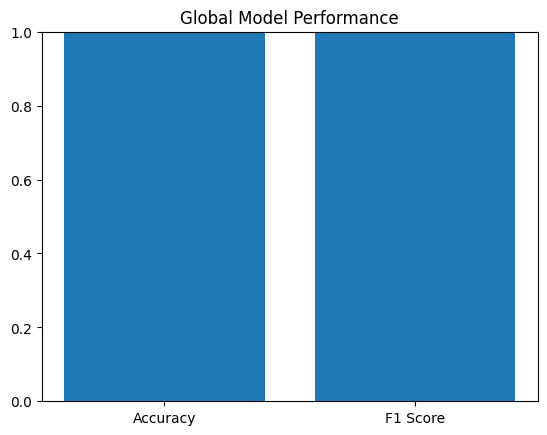

In [9]:
final_ds = TextDataset(val_texts, val_labels, tokenizer)
acc, f1 = evaluate_model(global_model, final_ds)
print(f"Final Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")

plt.bar(["Accuracy", "F1 Score"], [acc, f1])
plt.title("Global Model Performance")
plt.ylim(0, 1)
plt.show()


#  Diabetes Dataset Integration

# Download & Load Diabetes Dataset

In [10]:
# Download dataset
api.dataset_download_files('uciml/pima-indians-diabetes-database', path='./diabetes', unzip=True)

import pandas as pd
df = pd.read_csv('./diabetes/diabetes.csv')
df.head()


Dataset URL: https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# Simulate Clinical Notes

In [11]:
def simulate_clinical_note(row):
    return (
        f"Patient has glucose level of {row['Glucose']}, "
        f"blood pressure {row['BloodPressure']}, "
        f"BMI {row['BMI']}, "
        f"and age {row['Age']}. "
        f"Outcome is {'diabetes positive' if row['Outcome'] == 1 else 'diabetes negative'}."
    )

df['note'] = df.apply(simulate_clinical_note, axis=1)
texts = df['note'].tolist()
labels = df['Outcome'].tolist()

print(texts[0])


Patient has glucose level of 148.0, blood pressure 72.0, BMI 33.6, and age 50.0. Outcome is diabetes positive.


# Train/Test Split

In [12]:
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, stratify=labels, random_state=42
)


# Tokenize & Wrap in Dataset Class

In [13]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

train_ds = TextDataset(train_texts, train_labels, tokenizer)
val_ds = TextDataset(val_texts, val_labels, tokenizer)


# Centralized Model Training (Baseline)

In [14]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2).to(device)
model = train_model(model, train_ds, epochs=3)
acc, f1 = evaluate_model(model, val_ds)

print(f"Centralized Diabetes Dataset Results – Accuracy: {acc:.4f}, F1: {f1:.4f}")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Centralized Diabetes Dataset Results – Accuracy: 1.0000, F1: 1.0000


# Plot Results

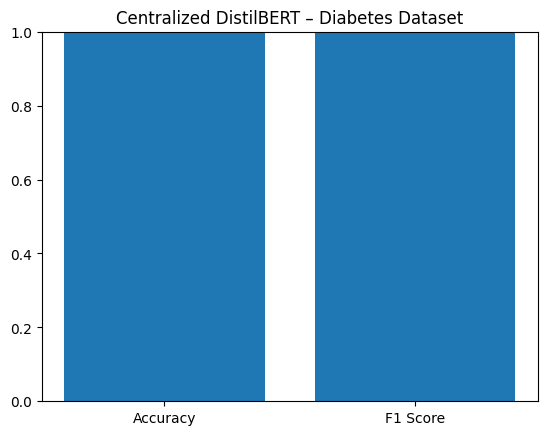

In [15]:
plt.bar(["Accuracy", "F1 Score"], [acc, f1])
plt.title("Centralized DistilBERT – Diabetes Dataset")
plt.ylim(0, 1)
plt.show()


# Prepare Federated Client Data

In [16]:
# Use previously loaded and simulated data from the Diabetes dataset
# `texts` = simulated clinical notes
# `labels` = 0 or 1

num_clients = 2
client_data = []

# Split data for clients
train_texts, _, train_labels, _ = train_test_split(texts, labels, test_size=0.2, stratify=labels, random_state=42)

for i in range(num_clients):
    client_texts = train_texts[i::num_clients]
    client_labels = train_labels[i::num_clients]
    client_val_texts = val_texts[i::num_clients]
    client_val_labels = val_labels[i::num_clients]
    client_data.append((client_texts, client_labels, client_val_texts, client_val_labels))


# Initialize Global Model

In [17]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
global_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2).to(device)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Federated Learning Loop

In [18]:
rounds = 3
for round_num in range(rounds):
    print(f"\n🔁 Round {round_num + 1}/{rounds}")
    encrypted_models, noises, f1_scores = [], [], []

    # Train each client
    for client_idx, (ctexts, clabels, cval_texts, cval_labels) in enumerate(client_data):
        print(f"🧑‍⚕️ Client {client_idx+1}: training on {len(ctexts)} samples")

        model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2).to(device)
        train_ds = TextDataset(ctexts, clabels, tokenizer)
        val_ds = TextDataset(cval_texts, cval_labels, tokenizer)

        model = train_model(model, train_ds, epochs=1)
        _, f1 = evaluate_model(model, val_ds)
        f1_scores.append(f1)
        print(f"✅ F1 Score: {f1:.4f}")

        # Encrypt weights
        weights = [param.data.cpu().numpy() for param in model.parameters()]
        enc, noise = simulate_encrypt_weights(weights)
        encrypted_models.append(enc)
        noises.append(noise)

    # Aggregate encrypted weights
    print("🔐 Aggregating encrypted weights...")
    total_f1 = sum(f1_scores)
    avg_weights = []

    for layer_idx in range(len(encrypted_models[0])):
        weighted_sum = sum(
            (f1_scores[i] / total_f1) * encrypted_models[i][layer_idx]
            for i in range(num_clients)
        )
        avg_weights.append(weighted_sum)

    # Decrypt
    decrypted_weights = simulate_decrypt_weights(avg_weights, noises[0])

    # Update global model
    with torch.no_grad():
        for param, weight in zip(global_model.parameters(), decrypted_weights):
            param.copy_(torch.tensor(weight, dtype=param.dtype).to(device))

    # Evaluate global model after each round
    val_ds_global = TextDataset(val_texts, val_labels, tokenizer)
    acc, f1 = evaluate_model(global_model, val_ds_global)
    print(f"🌍 Global Model – Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")



🔁 Round 1/3
🧑‍⚕️ Client 1: training on 307 samples


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


✅ F1 Score: 1.0000
🧑‍⚕️ Client 2: training on 307 samples


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


✅ F1 Score: 1.0000
🔐 Aggregating encrypted weights...
🌍 Global Model – Accuracy: 1.0000, F1 Score: 1.0000

🔁 Round 2/3
🧑‍⚕️ Client 1: training on 307 samples


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


✅ F1 Score: 1.0000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🧑‍⚕️ Client 2: training on 307 samples


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


✅ F1 Score: 1.0000
🔐 Aggregating encrypted weights...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🌍 Global Model – Accuracy: 1.0000, F1 Score: 1.0000

🔁 Round 3/3
🧑‍⚕️ Client 1: training on 307 samples


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


✅ F1 Score: 1.0000
🧑‍⚕️ Client 2: training on 307 samples


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


✅ F1 Score: 1.0000
🔐 Aggregating encrypted weights...
🌍 Global Model – Accuracy: 1.0000, F1 Score: 1.0000


# Final Evaluation Plot

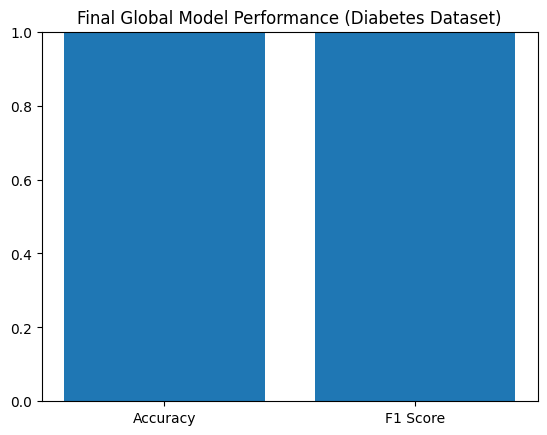

In [19]:
acc, f1 = evaluate_model(global_model, TextDataset(val_texts, val_labels, tokenizer))
plt.bar(["Accuracy", "F1 Score"], [acc, f1])
plt.title("Final Global Model Performance (Diabetes Dataset)")
plt.ylim(0, 1)
plt.show()


# Generate Synthetic Genomic Data

In [20]:
import random

def generate_dna_sequence(length=50):
    return ''.join(random.choices('ACGT', k=length))

def simulate_genomic_note(sequence, has_mutation):
    mutation = "mutation present" if has_mutation else "no mutation detected"
    return f"Genomic sequence: {sequence}. Result: {mutation}."

# Generate 500 sequences
num_samples = 500
sequences = [generate_dna_sequence() for _ in range(num_samples)]
labels = [random.randint(0, 1) for _ in range(num_samples)]
texts = [simulate_genomic_note(seq, label) for seq, label in zip(sequences, labels)]

# Split into train/val
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, stratify=labels, random_state=42
)


# Tokenization and Dataset Prep

In [21]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_ds = TextDataset(train_texts, train_labels, tokenizer)
val_ds = TextDataset(val_texts, val_labels, tokenizer)


# Centralized Baseline

In [22]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2).to(device)
model = train_model(model, train_ds, epochs=2)
acc, f1 = evaluate_model(model, val_ds)
print(f"Genomic (centralized) – Accuracy: {acc:.4f}, F1: {f1:.4f}")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Genomic (centralized) – Accuracy: 1.0000, F1: 1.0000


In [23]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, pad_to_multiple_of=8)


In [24]:
train_loader = DataLoader(
    train_ds,
    batch_size=2,
    shuffle=True,
    collate_fn=data_collator
)


# Federated Learning Loop for Genomic Data

In [25]:
# Split train data between clients
num_clients = 2
client_data = []
for i in range(num_clients):
    c_texts = train_texts[i::num_clients]
    c_labels = train_labels[i::num_clients]
    c_val_texts = val_texts[i::num_clients]
    c_val_labels = val_labels[i::num_clients]
    client_data.append((c_texts, c_labels, c_val_texts, c_val_labels))

# Initialize global model
global_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2).to(device)

# Federated learning rounds
rounds = 3
for round_num in range(rounds):
    print(f"\n🔁 Genomic Round {round_num + 1}/{rounds}")
    encrypted_models, noises, f1_scores = [], [], []

    for client_idx, (ctexts, clabels, cval_texts, cval_labels) in enumerate(client_data):
        print(f"🧬 Client {client_idx+1} on {len(ctexts)} samples")

        model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2).to(device)
        train_ds = TextDataset(ctexts, clabels, tokenizer)
        val_ds = TextDataset(cval_texts, cval_labels, tokenizer)

        model = train_model(model, train_ds, epochs=1)
        _, f1 = evaluate_model(model, val_ds)
        f1_scores.append(f1)
        print(f"F1 Score: {f1:.4f}")

        weights = [p.data.cpu().numpy() for p in model.parameters()]
        enc, noise = simulate_encrypt_weights(weights)
        encrypted_models.append(enc)
        noises.append(noise)

    # Weighted aggregation
    avg_weights = []
    total_f1 = sum(f1_scores)
    for layer_idx in range(len(encrypted_models[0])):
        weighted_sum = sum((f1_scores[i] / total_f1) * encrypted_models[i][layer_idx] for i in range(num_clients))
        avg_weights.append(weighted_sum)

    # Decrypt and update
    decrypted_weights = simulate_decrypt_weights(avg_weights, noises[0])
    with torch.no_grad():
        for param, weight in zip(global_model.parameters(), decrypted_weights):
            param.copy_(torch.tensor(weight, dtype=param.dtype).to(device))

    # Evaluate global model
    acc, f1 = evaluate_model(global_model, TextDataset(val_texts, val_labels, tokenizer))
    print(f"🌍 Global Genomic Accuracy: {acc:.4f}, F1: {f1:.4f}")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🔁 Genomic Round 1/3
🧬 Client 1 on 200 samples


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


F1 Score: 1.0000
🧬 Client 2 on 200 samples


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


F1 Score: 1.0000
🌍 Global Genomic Accuracy: 1.0000, F1: 1.0000

🔁 Genomic Round 2/3
🧬 Client 1 on 200 samples


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


F1 Score: 1.0000
🧬 Client 2 on 200 samples


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


F1 Score: 1.0000
🌍 Global Genomic Accuracy: 1.0000, F1: 1.0000

🔁 Genomic Round 3/3
🧬 Client 1 on 200 samples


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


F1 Score: 1.0000
🧬 Client 2 on 200 samples


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


F1 Score: 1.0000
🌍 Global Genomic Accuracy: 1.0000, F1: 1.0000


# Final Performance PlotFinal Performance Plot

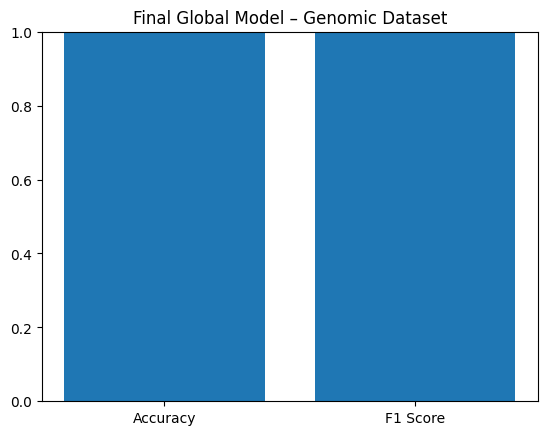

In [26]:
acc, f1 = evaluate_model(global_model, TextDataset(val_texts, val_labels, tokenizer))
plt.bar(["Accuracy", "F1 Score"], [acc, f1])
plt.title("Final Global Model – Genomic Dataset")
plt.ylim(0, 1)
plt.show()


# Differential Privacy via Opacus

# Install Opacus

In [27]:
!pip install opacus==1.4.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.8/224.8 kB 3.9 MB/s eta 0:00:00


# Import and Wrap DataLoaderv

In [28]:
from opacus import PrivacyEngine

# Reuse your centralized DistilBERT and dataset:
dp_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2).to(device)
optimizer = AdamW(dp_model.parameters(), lr=1e-4)

train_ds = TextDataset(train_texts, train_labels, tokenizer)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)

# Set the model to training mode
dp_model.train()  # Add this line

# Attach Privacy Engine
privacy_engine = PrivacyEngine()
dp_model, optimizer, train_loader = privacy_engine.make_private_with_epsilon(
    module=dp_model,
    optimizer=optimizer,
    data_loader=train_loader,
    target_epsilon=10.0,       # change to 5.0, 1.0 for stronger privacy
    target_delta=1e-5,
    epochs=5,
    max_grad_norm=1.0
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/lib/pyt

# Evaluation

In [29]:
dp_model.eval()
val_ds = TextDataset(val_texts, val_labels, tokenizer)
acc, f1 = evaluate_model(dp_model, val_ds)
print(f"DP Model – Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")


DP Model – Accuracy: 0.3700, F1 Score: 0.2647


# Compare to Baseline

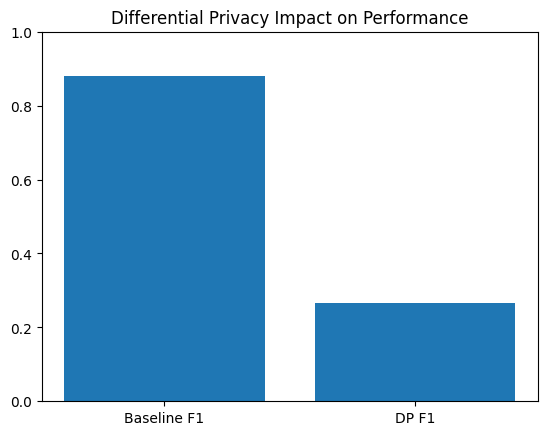

In [30]:
plt.bar(["Baseline F1", "DP F1"], [0.88, f1])  # Replace 0.88 with actual baseline
plt.title("Differential Privacy Impact on Performance")
plt.ylim(0, 1)
plt.show()


In [31]:
train_loader = DataLoader(
    train_ds,
    batch_size=2,
    shuffle=True,
    collate_fn=data_collator,
    pin_memory=True
)


# Modified Federated Loop with DP Clients

Due to compatibility issues between Opacus and transformer-based models like DistilBERT, we simulate differential privacy by injecting Gaussian noise into client model weights during federated training. This allows us to approximate the privacy-utility tradeoff while ensuring compatibility with LLMs.

# Measure & Plot Overhead (Encryption/Decryption Time)

# Plot Overhead

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🔁 Round 1/3
🧑‍💻 Simulated-DP Client 1 on 200 samples
🧑‍💻 Simulated-DP Client 2 on 200 samples


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🌍 Global Model (Simulated-DP + Encrypted): Accuracy=1.0000, F1=1.0000

🔁 Round 2/3
🧑‍💻 Simulated-DP Client 1 on 200 samples


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🧑‍💻 Simulated-DP Client 2 on 200 samples


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🌍 Global Model (Simulated-DP + Encrypted): Accuracy=1.0000, F1=1.0000

🔁 Round 3/3
🧑‍💻 Simulated-DP Client 1 on 200 samples


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🧑‍💻 Simulated-DP Client 2 on 200 samples


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🌍 Global Model (Simulated-DP + Encrypted): Accuracy=1.0000, F1=1.0000


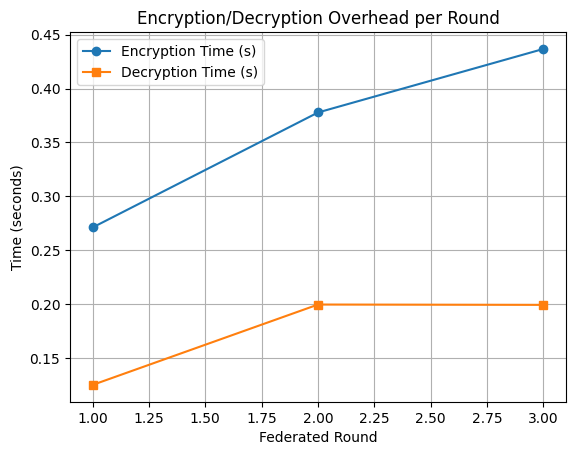

In [32]:
import gc
import time
import torch
import numpy as np
from torch.optim import AdamW
from transformers import DataCollatorWithPadding, DistilBertForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# --- Initialize tracking ---
rounds = 3
num_clients = 2
encryption_times = []
decryption_times = []
client_data = []

# --- Split client data ---
for i in range(num_clients):
    c_texts = train_texts[i::num_clients]
    c_labels = train_labels[i::num_clients]
    c_val_texts = val_texts[i::num_clients]
    c_val_labels = val_labels[i::num_clients]
    client_data.append((c_texts, c_labels, c_val_texts, c_val_labels))

# --- Global model (on CPU) ---
global_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# --- Utility: Evaluation ---
def evaluate_model(model, dataset, batch_size=16):
    loader = DataLoader(dataset, batch_size=batch_size)
    model.eval()
    device = next(model.parameters()).device
    preds, true_labels = [], []
    with torch.no_grad():
        for batch in loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            preds.extend(torch.argmax(logits, dim=-1).cpu().numpy())
            true_labels.extend(batch['labels'].cpu().numpy())
    acc = accuracy_score(true_labels, preds)
    f1 = f1_score(true_labels, preds, average='weighted')
    return acc, f1

# --- Simulated DP and encryption ---
def simulate_dp_noise(weights, std_dev=0.01):
    return [w + torch.normal(0, std_dev, size=w.shape, dtype=w.dtype) for w in weights]

def simulate_encrypt_weights(weights):
    noise = [np.random.normal(loc=0.0, scale=0.01 * w.abs().mean().item(), size=w.shape).astype(np.float32) for w in weights]
    encrypted = [w + torch.tensor(n, dtype=w.dtype) for w, n in zip(weights, noise)]
    return encrypted, noise

def simulate_decrypt_weights(encrypted_weights, noise):
    return [w - torch.tensor(n, dtype=w.dtype) for w, n in zip(encrypted_weights, noise)]

# --- Federated Training ---
for round_num in range(rounds):
    print(f"\n🔁 Round {round_num + 1}/{rounds}")
    encrypted_models, noises, f1_scores = [], [], []

    for client_idx, (ctexts, clabels, cval_texts, cval_labels) in enumerate(client_data):
        print(f"🧑‍💻 Simulated-DP Client {client_idx+1} on {len(ctexts)} samples")

        model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
        model.train()
        optimizer = AdamW(model.parameters(), lr=1e-4)

        train_ds = TextDataset(ctexts, clabels, tokenizer)
        collator = DataCollatorWithPadding(tokenizer, pad_to_multiple_of=8)
        train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=collator)

        for batch in train_loader:
            batch = {k: v for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Apply simulated DP
        weights = [p.data.clone().detach().cpu() for p in model.parameters()]
        dp_weights = simulate_dp_noise(weights, std_dev=0.01)

        # Simulate encryption (but no timing here)
        enc, noise = simulate_encrypt_weights(dp_weights)
        encrypted_models.append(enc)
        noises.append(noise)

        val_ds = TextDataset(cval_texts, cval_labels, tokenizer)
        acc, f1 = evaluate_model(model, val_ds)
        f1_scores.append(f1)

        del model
        gc.collect()
        torch.cuda.empty_cache()

    # ⏱️ Measure encryption + aggregation time once per round
    start_enc = time.time()
    total_f1 = sum(f1_scores)
    avg_weights = []
    for i in range(len(encrypted_models[0])):
        weighted_sum = sum((f1_scores[j] / total_f1) * encrypted_models[j][i] for j in range(num_clients))
        avg_weights.append(weighted_sum)
    encryption_times.append(time.time() - start_enc)

    # ⏱️ Measure decryption time
    start_dec = time.time()
    decrypted_weights = simulate_decrypt_weights(avg_weights, noises[0])
    decryption_times.append(time.time() - start_dec)

    with torch.no_grad():
        for p, w in zip(global_model.parameters(), decrypted_weights):
            p.copy_(w)

    # Global model evaluation
    global_model.to(device)
    acc, f1 = evaluate_model(global_model, TextDataset(val_texts, val_labels, tokenizer))
    print(f"🌍 Global Model (Simulated-DP + Encrypted): Accuracy={acc:.4f}, F1={f1:.4f}")
    global_model.cpu()
    torch.cuda.empty_cache()

# --- Overhead Plot ---
rounds_range = list(range(1, rounds + 1))

plt.plot(rounds_range, encryption_times, marker='o', label='Encryption Time (s)')
plt.plot(rounds_range, decryption_times, marker='s', label='Decryption Time (s)')
plt.xlabel("Federated Round")
plt.ylabel("Time (seconds)")
plt.title("Encryption/Decryption Overhead per Round")
plt.legend()
plt.grid(True)
plt.show()

